# Physical Activity & Fitness Analysis

## Introduction

Physical activity is defined as the movement of the human body produced by muscle contraction that generates energy expenditure above the resting metabolic level, and it's closely related to physical exercise and fitness. 

Physical exercise is a planned, structured and repeated body movement performed to maintain or improve one or more components of physical fitness. We understand "Fitness" as the set of attributes or qualities that people have or acquire to improve performance.

Nowadays, thanks to technology we can take an in-depth analytical look at my trainings: running styles, training habits, and achievements. Helped with a GPS fitness tracker you can analyze your workout routines to see how are you performing.

If lockdown has inspired you to lace up your trainers and get running, you’re not alone. And if you haven’t yet – as the days get longer and exercise restrictions are eased, it’s a great time to start.

## Objetive

Runkeeper is an app that lets you keep track of your progress as your running journey goes. Users can see their stats to check just how far they’ve come, if you are a data enthusiast making a depth analysis would be an interesting way yo get some insights of your progress and performance, and that's exactly what we are going to do.

## Data

Fortunately, the app counts with a handy import feature. It’s designed for people with activity data saved on other devices or systems but want to import those activities. 

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")
%matplotlib inline

workout = pd.read_csv('Workout_data.csv', index_col = 'Date', parse_dates = ['Date'])
display(workout.sample(3))
print(workout.info())

,Activity Id,Type,Route Name,Distance (km),Duration,Average Pace,Average Speed (km/h),Calories Burned,Climb (m),Average Heart Rate (bpm),Friend's Tagged,Notes,GPX File
Date,,,,,,,,,,,,,
2013-04-13 08:51:29,2c971ecf-efdd-4a3d-be67-ba249aa5557a,Running,NaN,6.34,33:02,5:13,11.51,454.0,33,NaN,NaN,NaN,2013-04-13-085129.gpx
2016-12-06 18:36:37,159d92f4-c96b-43ea-88a3-8f1060d170ed,Running,NaN,6.99,41:34,5:57,10.08,500.0,49,139.0,NaN,TomTom MySports Watch,2016-12-06-183637.gpx
2013-07-19 18:40:13,0547ce8b-c7c8-40b6-bb71-feff6298c5be,Running,NaN,1.72,8:33,4:58,12.07,40.0,6,NaN,NaN,NaN,2013-07-19-184013.gpx


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 508 entries, 2018-11-11 14:05:12 to 2012-08-22 18:53:54
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Activity Id               508 non-null    object 
 1   Type                      508 non-null    object 
 2   Route Name                1 non-null      object 
 3   Distance (km)             508 non-null    float64
 4   Duration                  508 non-null    object 
 5   Average Pace              508 non-null    object 
 6   Average Speed (km/h)      508 non-null    float64
 7   Calories Burned           508 non-null    float64
 8   Climb (m)                 508 non-null    int64  
 9   Average Heart Rate (bpm)  294 non-null    float64
 10  Friend's Tagged           0 non-null      float64
 11  Notes                     231 non-null    object 
 12  GPX File                  504 non-null    object 
dtypes: float64(5), int64(1), obj

### Data Preprocessing

We hae columns that contain irrelevant data for our analysis, so we are going to get rid of them, addicionally we are going to look after missing values and fill them with the average value of the column.

In [23]:
cols = ['Notes', 'Calories Burned', 'GPX File', 'Activity Id', 'Friend\'s Tagged', 'Route Name']
workout.drop(columns=cols, inplace=True)
display(workout.Type.value_counts())
workout['Type'] = workout.Type.str.replace("Other", "Unicycling")
workout.isnull().sum()

Running    459
Cycling     29
Walking     18
Other        2
Name: Type, dtype: int64

Type                          0
Distance (km)                 0
Duration                      0
Average Pace                  0
Average Speed (km/h)          0
Climb (m)                     0
Average Heart Rate (bpm)    214
dtype: int64

In [24]:
cycle_avg = workout[workout['Type'] == 'Cycling']['Average Heart Rate (bpm)'].mean()
run_avg = workout[workout['Type'] == 'Running']['Average Heart Rate (bpm)'].mean()

walk = workout[workout['Type'] == 'Walking'].copy()
cycle = workout[workout['Type'] == 'Cycling'].copy()
run = workout[workout['Type'] == 'Running'].copy()

run['Average Heart Rate (bpm)'].fillna(int(run_avg), inplace=True)
cycle['Average Heart Rate (bpm)'].fillna(int(cycle_avg), inplace=True)
walk['Average Heart Rate (bpm)'].fillna(110, inplace=True)

run.isnull().sum()

Type                        0
Distance (km)               0
Duration                    0
Average Pace                0
Average Speed (km/h)        0
Climb (m)                   0
Average Heart Rate (bpm)    0
dtype: int64

## Exploratory Data Analysis

Let's find out about the runnig metrics using a visualization of the five years the data was collected. We want a subplot for each metric, but with an idenpendent y axis for each one, the x axis will be shared.

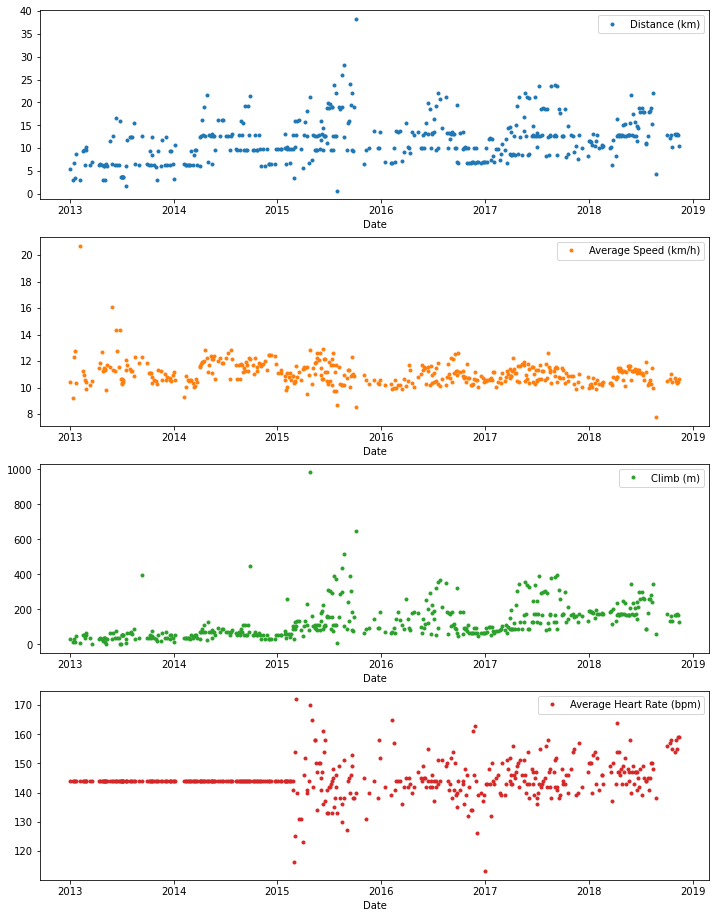

In [26]:
run_13_18 = run['20190101':'20130101']
run_13_18.plot(subplots=True,
          sharex=False,
          figsize=(12,16),
          linestyle='none',
          marker='o',
          markersize=3)

plt.show()

It seems that by some reason Hearth rate has many missing values, that may be due to it wasn't being recorded. Looking at this metrics it may seem that we can look and find patterns just by sight, but We want to go further and get real numbers that can answer some common questions among fit people:

* How often do I train?
* How fast do I run?
* What is my average distance?

So, lets answer those questions by making some calculations. We are going to use data from 2015 to 2018 since it has the heart rate recorded. 

Lets also plot long term averages of my distance run and my heart rate with their raw data to visually compare the averages to each training session.

In [28]:
run_15_18 = run['20190101':'20150101']

print('Running last 4 years average:')
display(run_15_18.resample('A').mean())

print('Last 4 years weekly average:')
display(run_15_18.resample('W').mean().mean())

weekly_training = run_15_18['Distance (km)'].resample('W').count().mean()
print('Average trainings per week:', weekly_training)

Running last 4 years average:


,Distance (km),Average Speed (km/h),Climb (m),Average Heart Rate (bpm)
Date,,,,
2015-12-31,13.602805,10.998902,160.170732,143.353659
2016-12-31,11.411667,10.837778,133.194444,143.388889
2017-12-31,12.935176,10.959059,169.376471,145.247059
2018-12-31,13.339063,10.777969,191.218750,148.125000


Last 4 years weekly average:


Distance (km)                12.518176
Average Speed (km/h)         10.835473
Climb (m)                   158.325444
Average Heart Rate (bpm)    144.801775
dtype: float64

Average trainings per week: 1.5


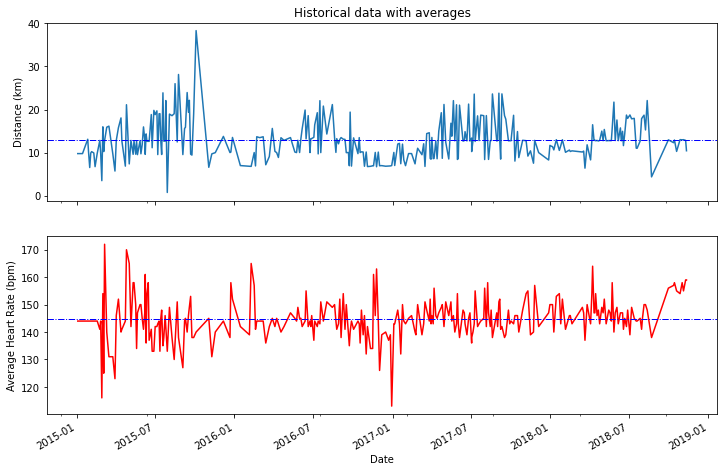

In [55]:
run_dist = run_15_18['Distance (km)']
run_hr = run_15_18['Average Heart Rate (bpm)']

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))

run_dist.plot(ax=ax1)
ax1.set(ylabel='Distance (km)', title='Historical data with averages')
ax1.axhline(run_dist.mean(), color='blue', linewidth=1, linestyle='-.')

run_hr.plot(ax=ax2, color='red')
ax2.set(xlabel='Date', ylabel='Average Heart Rate (bpm)')
ax2.axhline(run_hr.mean(), color = 'blue', linewidth=1, linestyle='-.')

plt.show()

Motivation is also important. And a visual of your goals can help you reach them. so lets say that we set a goal for 1000 km per year, through 2013-2018 lets see if we reach the goal marked by a star and dividing our graph in 3 areas. 

Lets also answer how are we progressing in running skills by decomposing the weekly distance runned and visually compare it to the original data.

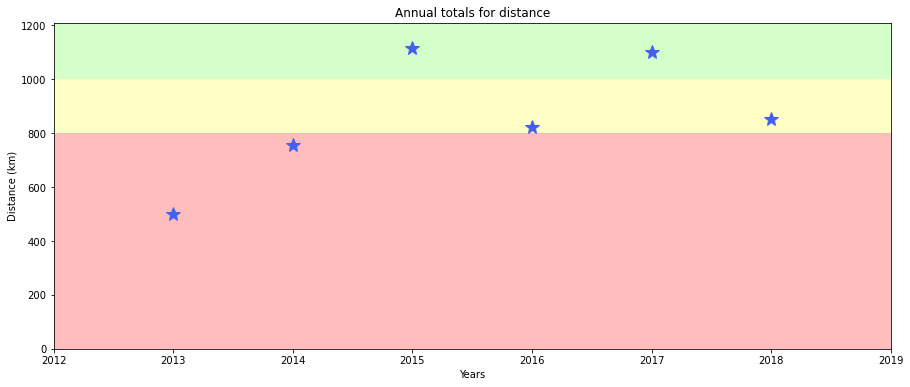

In [52]:
run_annual = run['2018':'2013']['Distance (km)'].resample('A').sum()

fig = plt.figure(figsize=(15.0, 6.0))
ax = run_annual.plot(marker='*', markersize=14, linewidth=0, color='#4361EE')
ax.set(ylim=[0, 1210], 
       xlabel='Years',
       title='Annual totals for distance',
       xlim=['2012','2019'],
       ylabel='Distance (km)')

ax.axhspan(1000, 1210, color='#CAFFBF', alpha=0.8)
ax.axhspan(800, 1000, color='#FDFFB6', alpha=0.8)
ax.axhspan(0, 800, color='#FFADAD', alpha=0.8)

plt.show()

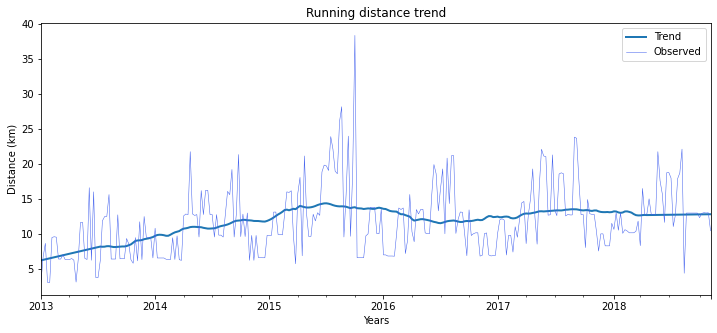

In [59]:
run_dist_wk = run['2018':'2013']['Distance (km)'].resample('W').bfill()
x = sm.tsa.seasonal_decompose(run_dist_wk, extrapolate_trend=1, freq=52)

fig = plt.figure(figsize=(12, 5))
ax = x.trend.plot(label='Trend', linewidth=2)
ax = x.observed.plot(label='Observed', linewidth=0.5, color='#4361EE')
ax.legend()
ax.set(xlabel='Years',
       ylabel='Distance (km)')
ax.set_title('Running distance trend')
plt.show()

For our last metric visualization we are going to use the heart rate since a popular metric used to measure training intensity. Depending on age and fitness level, heart rates are grouped into different zones that people can target depending on training goals. A target heart rate during moderate-intensity activities is about 50-70% of maximum heart rate, while during vigorous physical activity it’s about 70-85% of maximum. We are going to define som training zones and see the hearth rate distribution by training intensity.

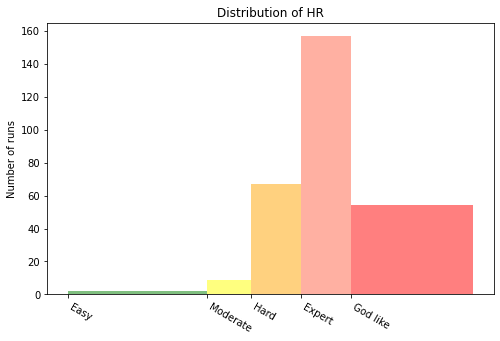

In [58]:
zone = [100, 125, 133, 142, 151, 173]
name = ['Easy', 'Moderate', 'Hard', 'Expert', 'God Like']
color = ['green', 'yellow', 'orange', 'tomato', 'red']
run_hr = run['2018':'2015 3']['Average Heart Rate (bpm)']

fig, ax = plt.subplots(figsize=(8, 5))
n, bins, patches = ax.hist(run_hr, bins=zone, alpha=0.5)
for i in range(0, len(patches)):
    patches[i].set_facecolor(color[i])
ax.set(title='Distribution of HR', ylabel='Number of runs')
ax.xaxis.set(ticks=zone[0:5])
ax.set_xticklabels(labels=name, rotation=-30, ha='left')

plt.show()

## Summary

By this time we have already have visualizated and analyzed our workout performance, however a summary showing our totals would be a great resource. First, we want a summary of the distance (km) and climb (m) variables for each workout type. And second, we want the statistics for the average speed (km/hr), climb (m), and distance (km) variables for each workout type. 

In [57]:
run_walk_cycle = df_run.append(walk).append(cycle).sort_index(ascending=False)
dist_climb, speed_col = ['Distance (km)', 'Climb (m)'], ['Average Speed (km/h)']
totals = run_walk_cycle.groupby('Type')[dist_climb].sum()

print('Training types totals:')
display(totals)

summary = run_walk_cycle.groupby('Type')[dist_climb + speed_col].describe()
for i in dist_climb:
    summary[i, 'total'] = totals[i]
print('Training types statistics summary:')
summary.stack()

Training types totals:


,Distance (km),Climb (m)
Type,,
Cycling,680.58,6976
Running,5224.50,57278
Walking,33.45,349


Training types statistics summary:


Average Speed (km/h)     Climb (m)  Distance (km)
Type                                                            
Cycling 25%               16.980000    139.000000      15.530000
        50%               19.500000    199.000000      20.300000
        75%               21.490000    318.000000      29.400000
        count             29.000000     29.000000      29.000000
        max               24.330000    553.000000      49.180000
        mean              19.125172    240.551724      23.468276
        min               11.380000     58.000000      11.410000
        std                3.257100    128.960289       9.451040
        total                   NaN   6976.000000     680.580000
Running 25%               10.495000     54.000000       7.415000
        50%               10.980000     91.000000      10.810000
        75%               11.520000    171.000000      13.190000
        count            459.000000    459.000000     459.000000
        max               20.720000    982.000000      38.320000
        mean              11.056296    124.788671      11.382353
        min                5.770000      0.000000       0.760000
        std                0.953273    103.382177       4.937853
        total                   NaN  57278.000000    5224.500000
Walking 25%                5.555000      7.000000       1.385000
        50%                5.970000     10.000000       1.485000
        75%                6.512500     15.500000       1.787500
        count             18.000000     18.000000      18.000000
        max                6.910000    112.000000       4.290000
        mean               5.549444     19.388889       1.858333
        min                1.040000      5.000000       1.220000
        std                1.459309     27.110100       0.880055
        total                   NaN    349.000000      33.450000

## Conclusions and Recommendations

It is important to engage in regular physical activity in order to maintain a healthy lifestyle however a large portion of the population is insufficiently active. 

Keeping track of your workout data can help you to improve your performance and keep motivation. If you are a data enthusiast making a custom analysis of your data would be a useful and interesting way yo get some insights of your progress.